In [63]:
# notebooks/create_scenarios.ipynb

from scripts.create_data import create_data_scenario
from scripts.logger import log_scenario_folder, mark_log_as_finished
import random
from datetime import datetime
from scripts.logger import create_new_id
import os

# Initialize logging ID
logs_id = create_new_id("scenario")

num_scenarios = 1000
amount_aircraft = 6
probabilistic_type = 'mixed'
probabilities_values_type = 'high'





if probabilistic_type == 'stochastic':
    amount_aircraft_disrupted = 0
    amount_aircraft_uncertain = 2
elif probabilistic_type == 'deterministic':
    amount_aircraft_disrupted = 2
    amount_aircraft_uncertain = 0
elif probabilistic_type == 'mixed':
    amount_aircraft_disrupted = 1
    amount_aircraft_uncertain = 1
else:
    raise ValueError(f"Invalid probabilistic_type: {probabilistic_type}")


if probabilistic_type != 'deterministic':
    if probabilities_values_type == 'high':
        prob_lower_bound = 0.5
        prob_upper_bound = 0.9
    elif probabilities_values_type == 'low':
        prob_lower_bound = 0.1
        prob_upper_bound = 0.5
    elif probabilities_values_type == 'medium':
        prob_lower_bound = 0.3
        prob_upper_bound = 0.7
    else:
        raise ValueError(f"Invalid probabilities_values_type: {probabilities_values_type}")
else:
    prob_lower_bound = 0.0
    prob_upper_bound = 0.0
    probabilities_values_type = 'na'



# Define logging inputs
logging_inputs = {
    "num_scenarios": num_scenarios,
    "aircraft_range": (amount_aircraft, amount_aircraft),
    "amount_aircraft_disrupted": amount_aircraft_disrupted,
    "amount_aircraft_uncertain": amount_aircraft_uncertain,
    "average_flights_per_aircraft": 12,
    "std_dev_flights_per_aircraft": 1,
    "min_delta_start_unavailability": 120,
    "max_delta_start_unavailability": 480,
    "min_period_unavailability": 120,
    "max_period_unavailability": 480,
    "probability_range": (prob_lower_bound, prob_upper_bound),
    "probability_distribution": 'uniform',
    "clear_one_random_aircraft": True,
    "clear_random_flights": True,
    "switch_one_random_flight_to_the_cleared_aircraft": True,
    "first_flight_dep_time_range": (6, 8),
    "flight_length_range": (2, 5),
    "time_between_flights_range": (0, 1),
}

# Fixed inputs
template_folder = "../data/Template"
data_root_folder = f"../data/Training/{amount_aircraft}ac-{logging_inputs['num_scenarios']}-{probabilistic_type}-{probabilities_values_type}/"
airports = [
    'AMS', 'CDG', 'FRA', 'LHR', 'MAD', 'MUC', 'ORY', 'TXL', 'VIE', 'ZRH', 
    'BCN', 'BRU', 'CPH', 'DUB', 'IST'
]
aircraft_types = [
    {'Model': 'A320', 'Family': 'Airbus', 'Config': '0/0/123', 'Dist': 5000, 'Cost/h': 1800.0, 
     'TurnRound': 30, 'Transit': 30, 'Orig': ['CFE'], 'Maint': ['NULL']}
    # Add more aircraft types if needed
]
config_dict = {
    'DelayCosts': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 100.0}],
    'CancellationCostsOutbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 500.0}],
    'CancellationCostsInbound': [{'Cabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 600.0}],
    'DowngradingCosts': [{'FromCabin': 'Business', 'ToCabin': 'Economy', 'Type': 'ShortHaul', 'Cost': 200.0}],
    'PenaltyCosts': [200, 300, 400],
    'Weights': [1.0, 0.5, 0.2],
}

# Initialize outputs dictionary
logging_outputs = {}

# Function to generate scenarios
for i in range(1, logging_inputs["num_scenarios"] + 1):
    scenario_name = f'Scenario_{i:02d}'  # Dynamically generate scenario names
    recovery_start_date = datetime(2024, 9, random.randint(1, 30)).strftime('%d/%m/%y')
    recovery_start_time = f'{random.randint(5, 7)}:00'
    recovery_end_date = recovery_start_date
    recovery_end_time = f'{random.randint(20, 23)}:{random.choice(["00", "30"])}'

    # Call the function for each scenario
    data_folder, inputs, outputs = create_data_scenario(
        scenario_name=scenario_name,
        template_folder=template_folder,
        data_root_folder=data_root_folder,
        aircraft_types=aircraft_types,
        total_aircraft_range=logging_inputs["aircraft_range"],
        amount_aircraft_disrupted=logging_inputs["amount_aircraft_disrupted"],
        amount_aircraft_uncertain=logging_inputs["amount_aircraft_uncertain"],
        min_delta_start_unavailability=logging_inputs["min_delta_start_unavailability"],
        max_delta_start_unavailability=logging_inputs["max_delta_start_unavailability"],
        min_period_unavailability=logging_inputs["min_period_unavailability"],
        max_period_unavailability=logging_inputs["max_period_unavailability"],
        average_flights_per_aircraft=logging_inputs["average_flights_per_aircraft"],
        std_dev_flights_per_aircraft=logging_inputs["std_dev_flights_per_aircraft"],
        airports=airports,
        config_dict=config_dict,
        recovery_start_date=recovery_start_date,
        recovery_start_time=recovery_start_time,
        recovery_end_date=recovery_end_date,
        recovery_end_time=recovery_end_time,
        clear_one_random_aircraft=logging_inputs["clear_one_random_aircraft"],
        clear_random_flights=logging_inputs["clear_random_flights"],
        switch_one_random_flight_to_the_cleared_aircraft=logging_inputs["switch_one_random_flight_to_the_cleared_aircraft"],
        probability_range=logging_inputs["probability_range"],
        probability_distribution=logging_inputs["probability_distribution"],
        first_flight_dep_time_range=logging_inputs["first_flight_dep_time_range"],
        flight_length_range=logging_inputs["flight_length_range"],
        time_between_flights_range=logging_inputs["time_between_flights_range"],
    )

    # Add scenario outputs to logging_outputs
    logging_outputs[scenario_name] = outputs

# Define the full data_folder path (assuming all scenarios are in the same folder)
# If scenarios are in separate folders, adjust accordingly
# Here, since num_scenarios=1, it's straightforward
scenario_folder_path = os.path.join(data_root_folder, scenario_name)

# Log the scenarios
log_scenario_folder(
    logs_id=logs_id,
    scenario_folder_path=data_root_folder,
    inputs=logging_inputs,
    outputs=logging_outputs
)

# Mark the log as finished
mark_log_as_finished(logs_id, additional_info=data_root_folder)



Data creation for scenario Scenario_01 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_02 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_03 completed with 6 aircraft and 20 flights.
Data creation for scenario Scenario_04 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_05 completed with 6 aircraft and 17 flights.
Data creation for scenario Scenario_06 completed with 6 aircraft and 18 flights.
Data creation for scenario Scenario_07 completed with 6 aircraft and 12 flights.
Data creation for scenario Scenario_08 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_09 completed with 6 aircraft and 17 flights.
Data creation for scenario Scenario_10 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_11 completed with 6 aircraft and 16 flights.
Data creation for scenario Scenario_12 completed with 6 aircraft and 14 flights.
Data creation for scenario S

### Visualize them

Processing scenario: Scenario_01
{'A320#4': {'StartDate': '19/09/24', 'StartTime': '11:42', 'EndDate': '19/09/24', 'EndTime': '18:45', 'Probability': 1.0}, 'A320#2': {'StartDate': '19/09/24', 'StartTime': '09:36', 'EndDate': '19/09/24', 'EndTime': '12:45', 'Probability': 0.61}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1    90   272 |     2   326   484 |     3   538   684 |     4   691   834 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.61    276   465 |     5   195   337 |     6   362   625 |     7   627   878 |     -     - 

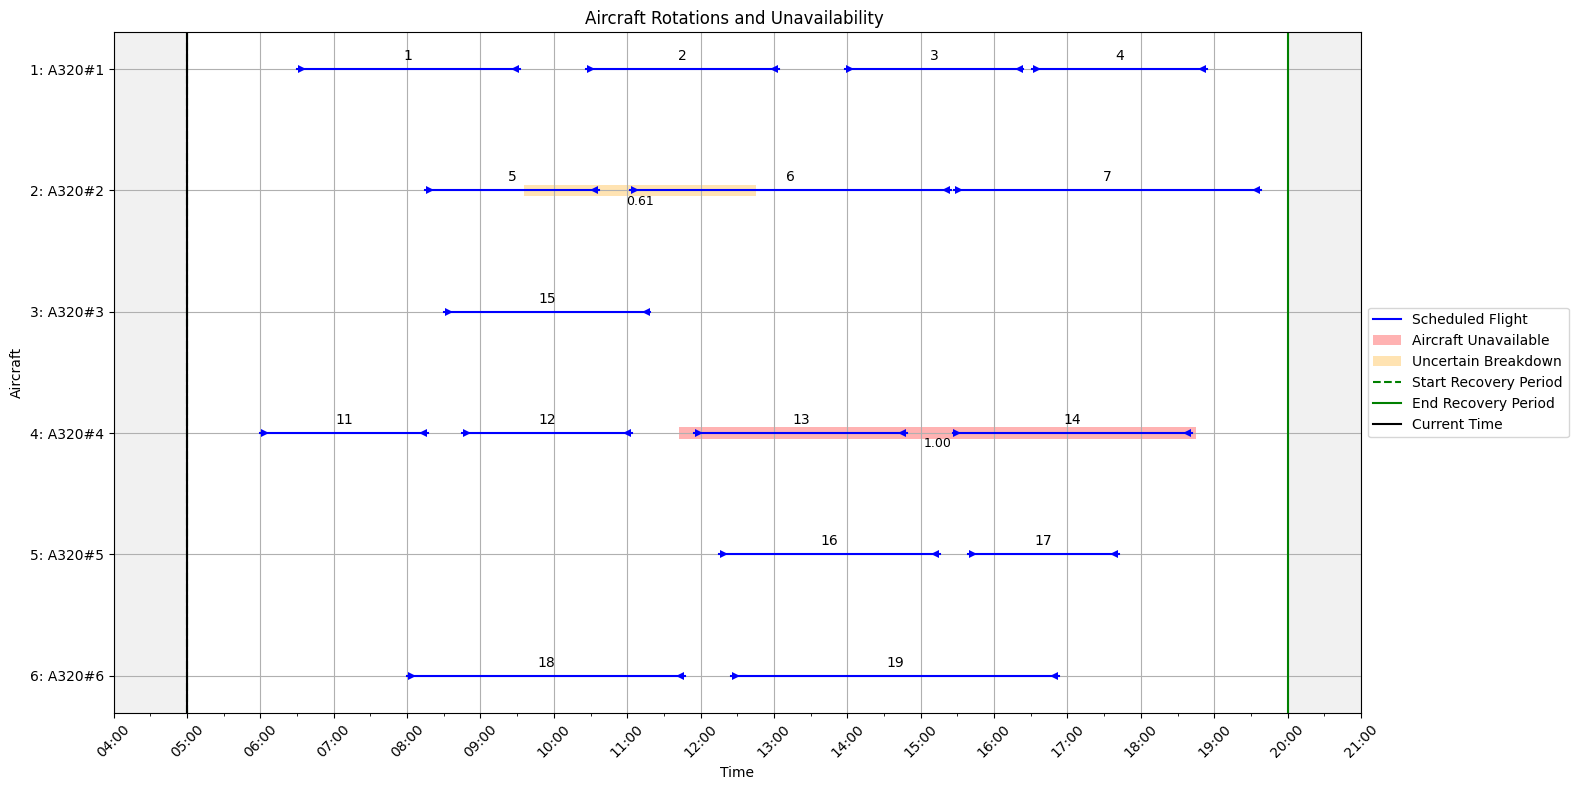

Processing scenario: Scenario_02
{'A320#4': {'StartDate': '04/09/24', 'StartTime': '11:55', 'EndDate': '04/09/24', 'EndTime': '15:53', 'Probability': 1.0}, 'A320#2': {'StartDate': '04/09/24', 'StartTime': '11:13', 'EndDate': '04/09/24', 'EndTime': '13:35', 'Probability': 0.57}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1    90   216 |     2   232   393 |     3   447   742 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.57    313   455 |     4   135   420 |     5   472   628 |     -     -     - |     -     - 

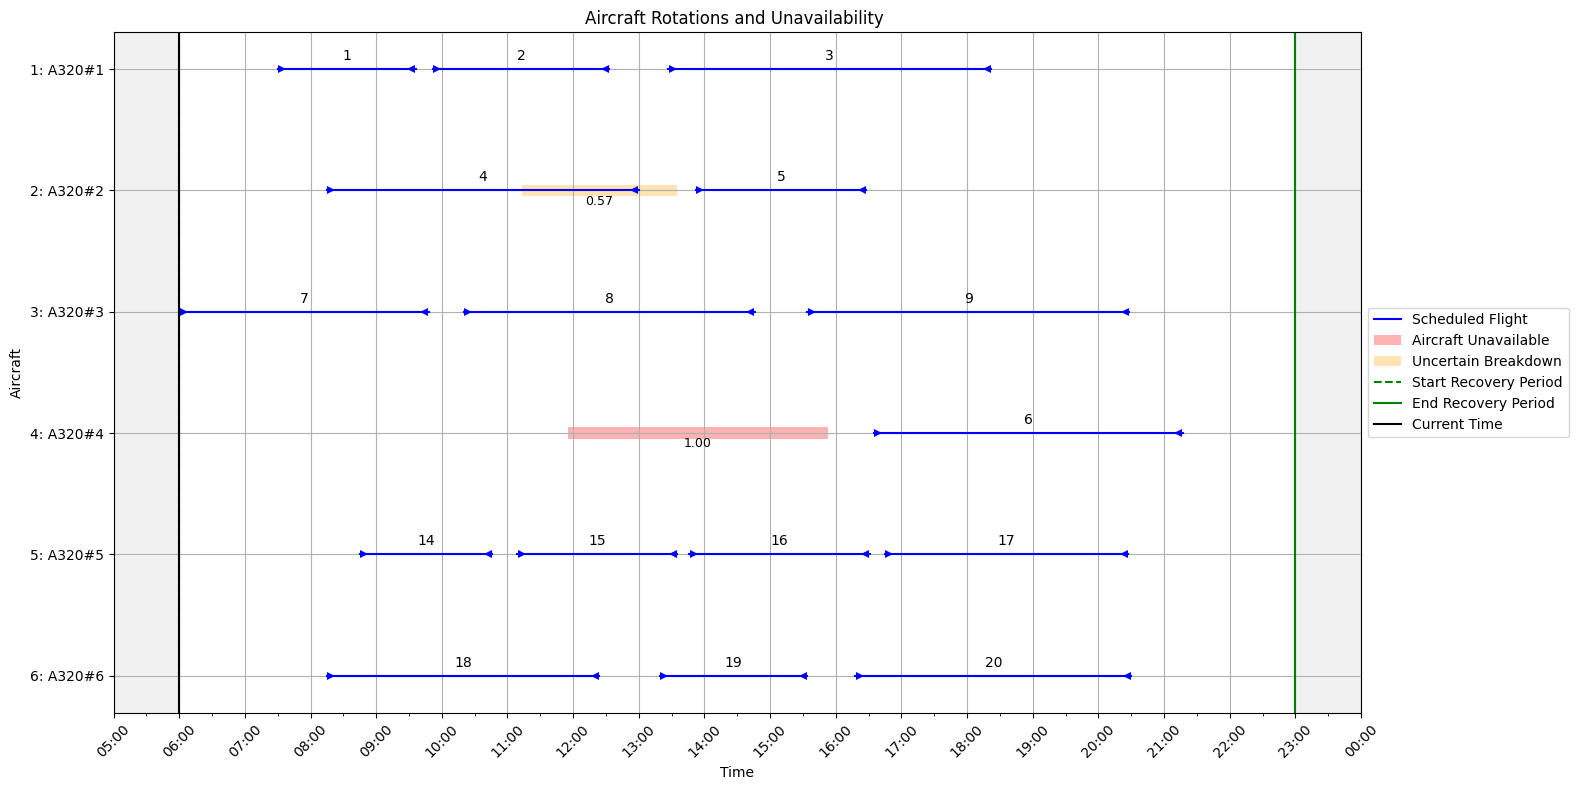

Processing scenario: Scenario_03
{'A320#3': {'StartDate': '04/09/24', 'StartTime': '11:11', 'EndDate': '04/09/24', 'EndTime': '18:42', 'Probability': 1.0}, 'A320#4': {'StartDate': '04/09/24', 'StartTime': '12:20', 'EndDate': '04/09/24', 'EndTime': '20:12', 'Probability': 0.7}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     2   212   408 |     3   426   552 |     4   579   750 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5    30   155 |     6   159   321 |     7   360   646 |     8   648  

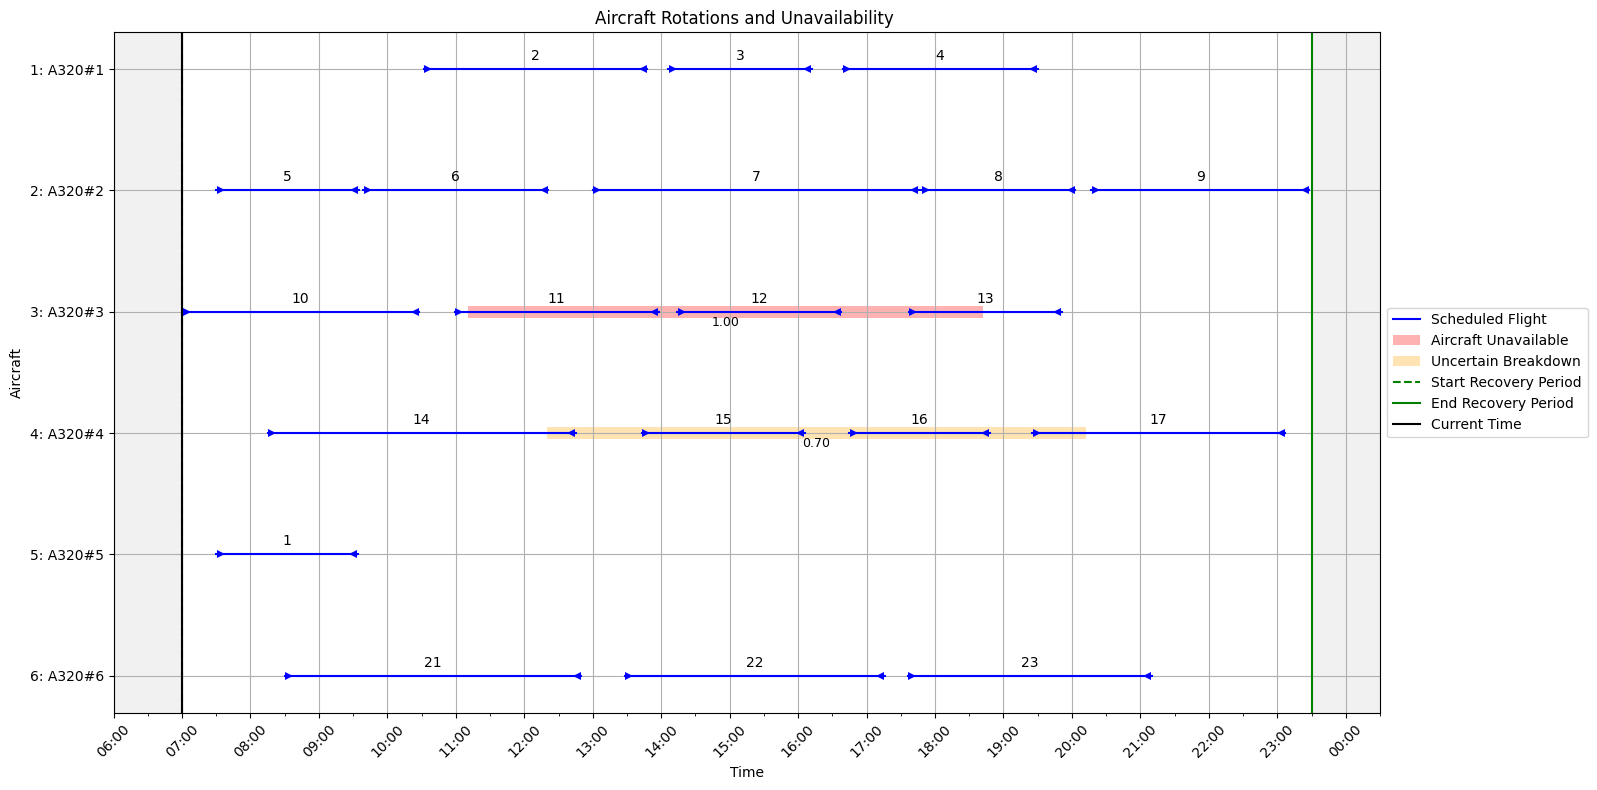

Processing scenario: Scenario_04
{'A320#4': {'StartDate': '06/09/24', 'StartTime': '08:42', 'EndDate': '06/09/24', 'EndTime': '14:47', 'Probability': 1.0}, 'A320#5': {'StartDate': '06/09/24', 'StartTime': '11:31', 'EndDate': '06/09/24', 'EndTime': '14:09', 'Probability': 0.68}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1     0   137 |     2   185   373 |     3   431   626 |     4   640   923 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5    15   143 |     6   166   427 |     7   436   696 |     -     - 

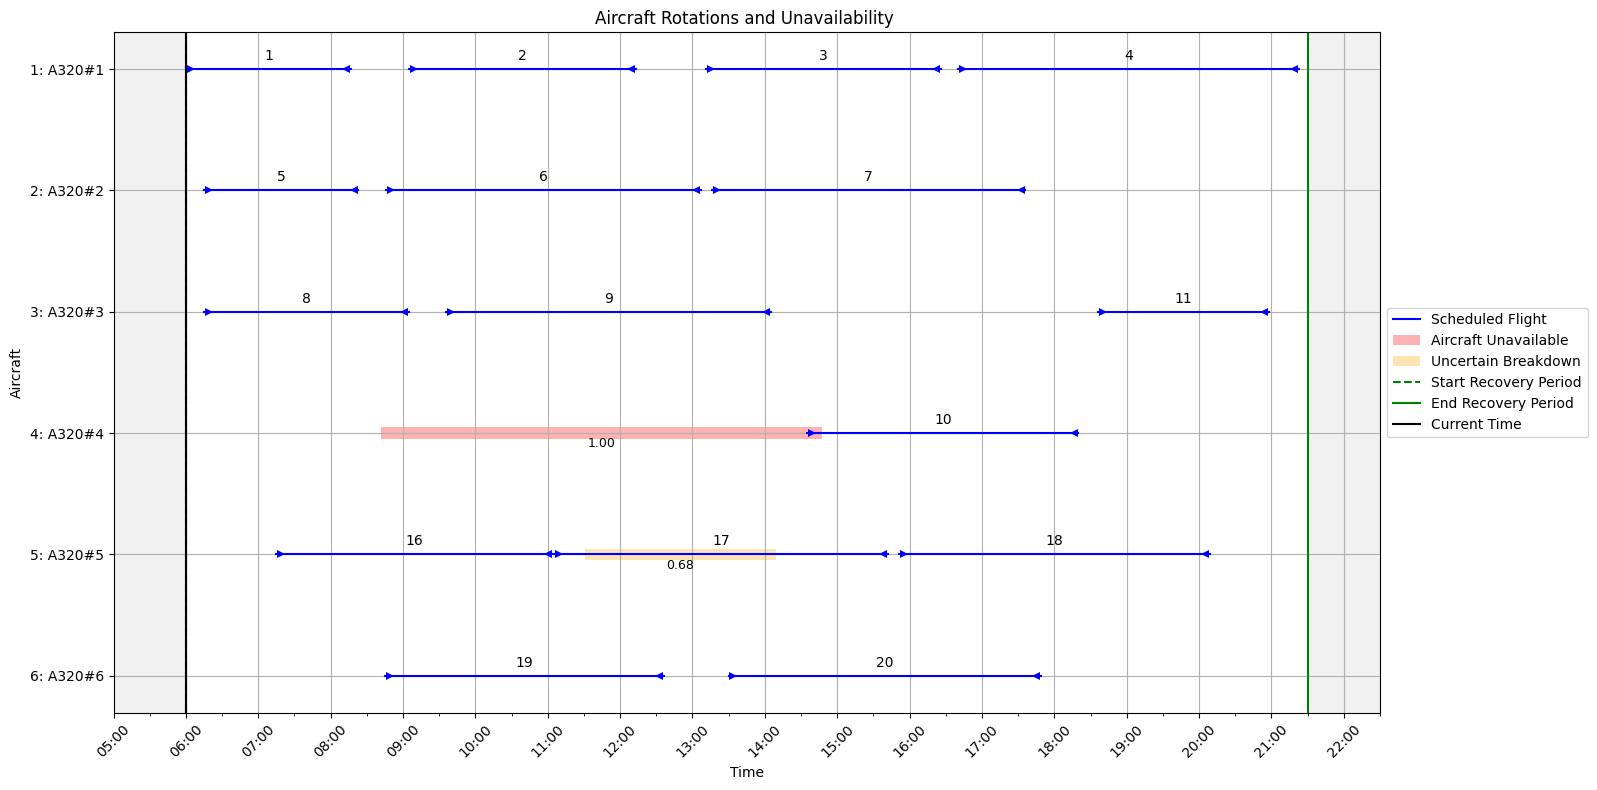

Processing scenario: Scenario_05
{'A320#6': {'StartDate': '18/09/24', 'StartTime': '11:32', 'EndDate': '18/09/24', 'EndTime': '15:28', 'Probability': 1.0}, 'A320#4': {'StartDate': '18/09/24', 'StartTime': '14:59', 'EndDate': '18/09/24', 'EndTime': '22:31', 'Probability': 0.82}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1    30   180 |     2   235   488 |     3   495   723 |     4   726   883 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5   105   306 |     6   343   631 |     7   689   854 |     -     - 

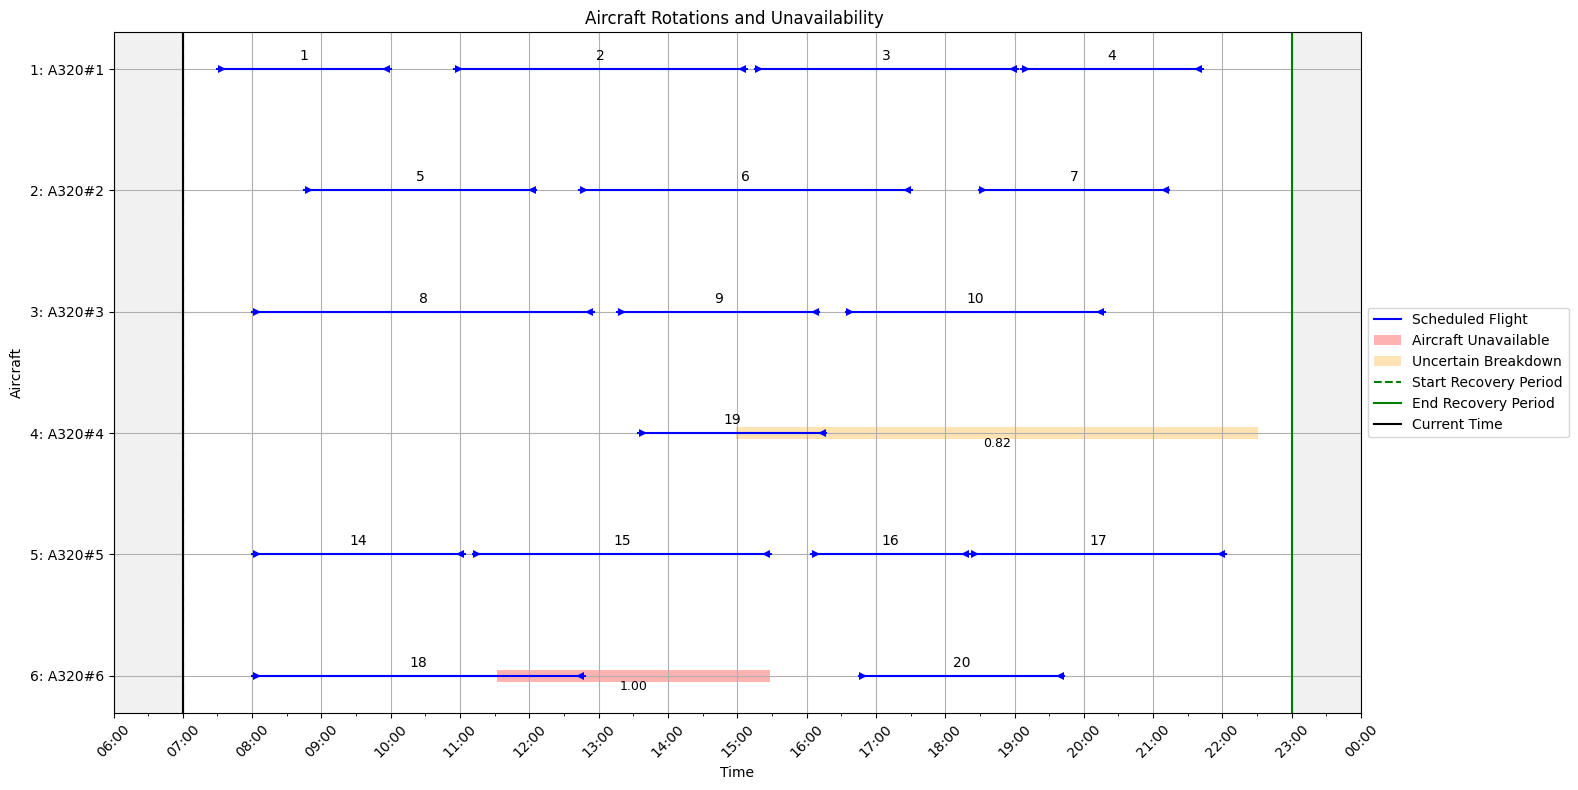

Processing scenario: Scenario_06
{'A320#1': {'StartDate': '21/09/24', 'StartTime': '09:31', 'EndDate': '21/09/24', 'EndTime': '14:43', 'Probability': 1.0}, 'A320#4': {'StartDate': '21/09/24', 'StartTime': '09:37', 'EndDate': '21/09/24', 'EndTime': '12:35', 'Probability': 0.67}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00    271   583 |    16   769   944 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5   165   302 |     6   343   557 |     7   600   812 |     8   822 

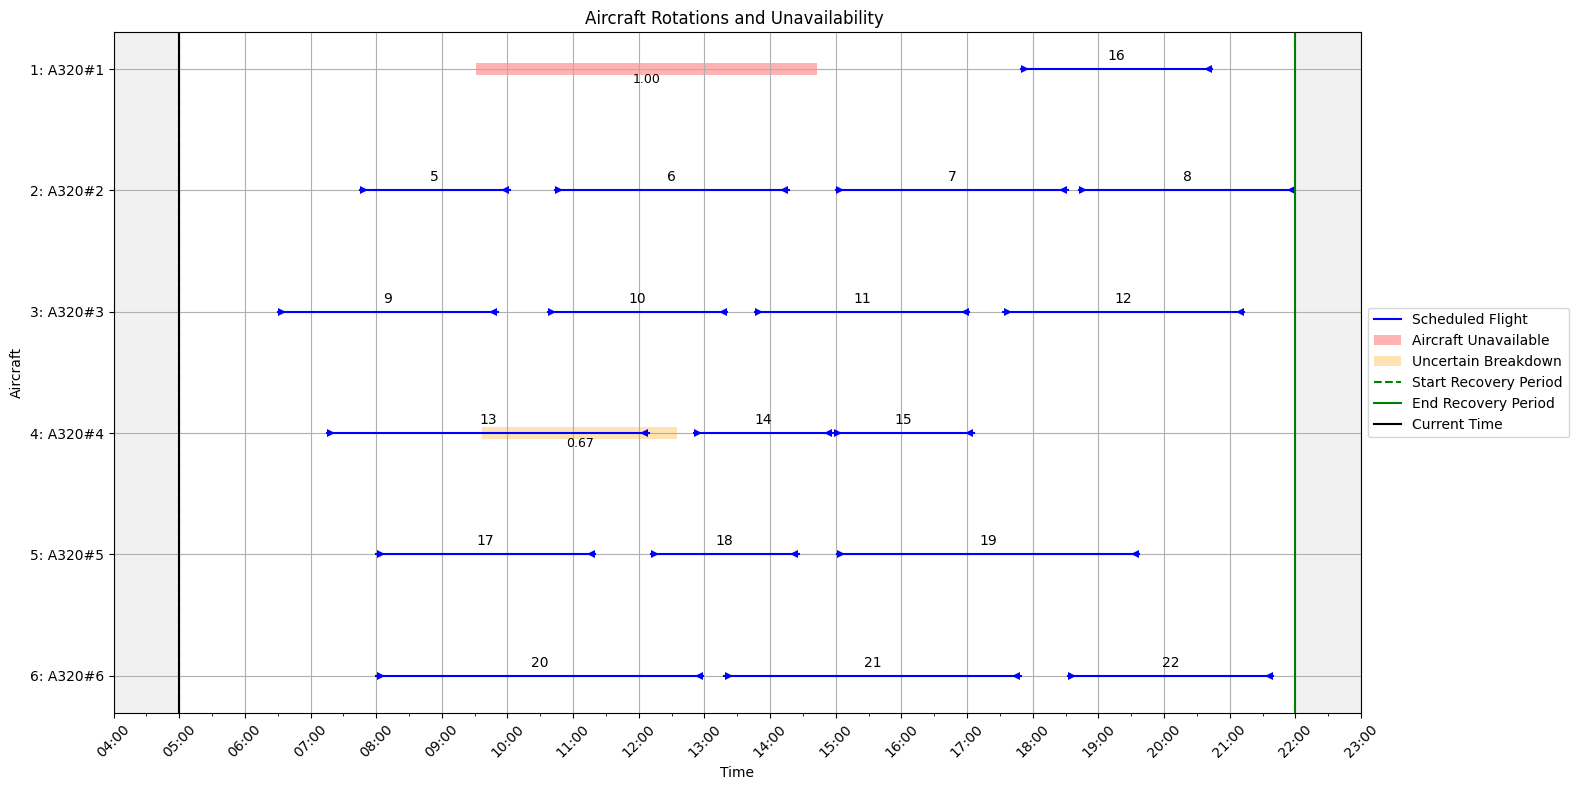

Processing scenario: Scenario_07
{'A320#1': {'StartDate': '01/09/24', 'StartTime': '12:24', 'EndDate': '01/09/24', 'EndTime': '17:36', 'Probability': 1.0}, 'A320#2': {'StartDate': '01/09/24', 'StartTime': '12:10', 'EndDate': '01/09/24', 'EndTime': '16:55', 'Probability': 0.8}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00    444   756 |     1   225   501 |     2   548   736 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   0.80    430   715 |    12   481   666 |     -     -     - |     -     -     - |     -     -  

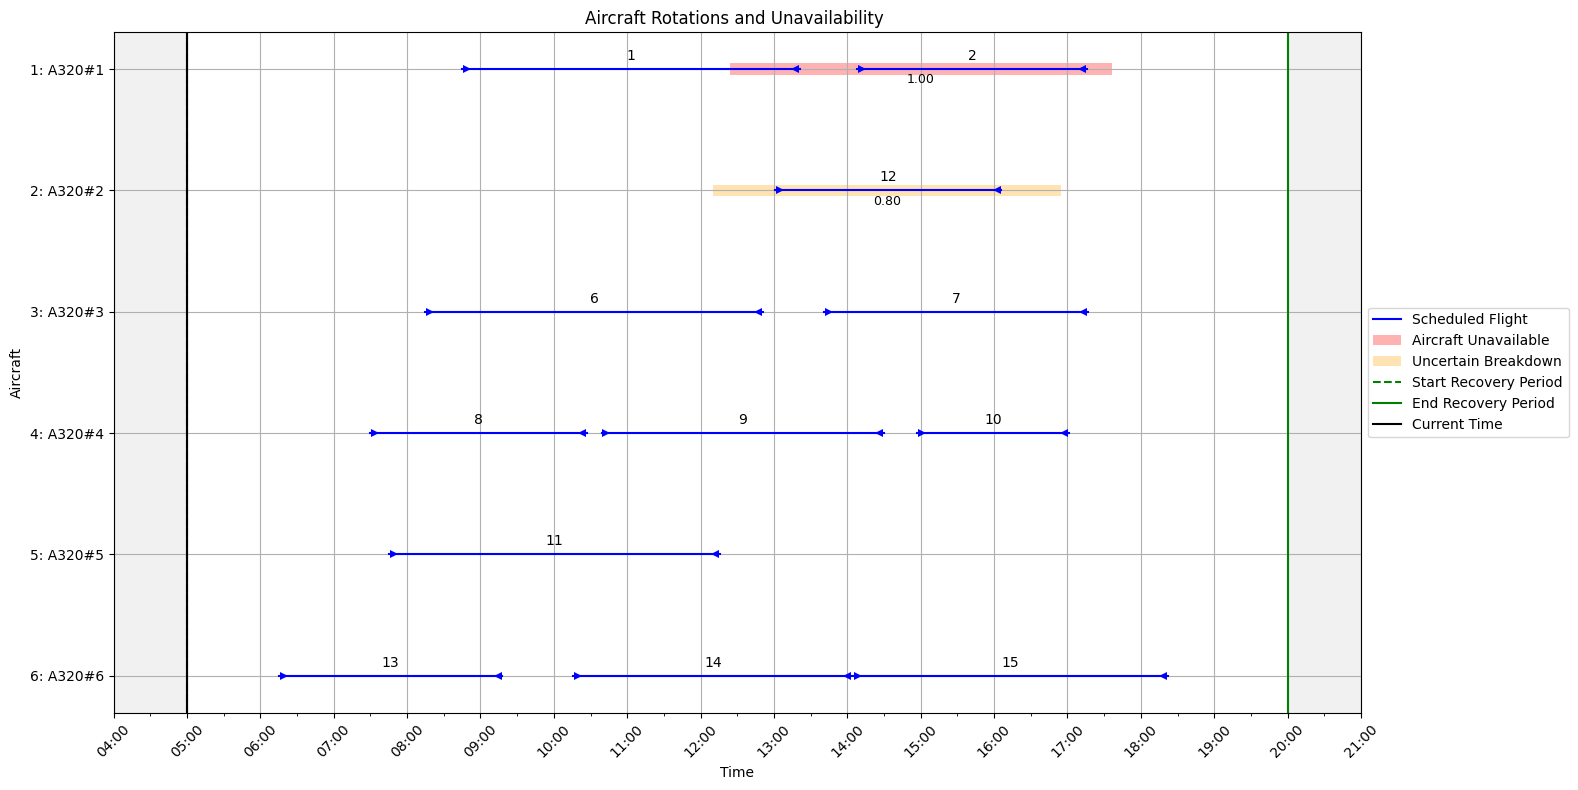

Processing scenario: Scenario_08
{'A320#1': {'StartDate': '11/09/24', 'StartTime': '10:43', 'EndDate': '11/09/24', 'EndTime': '16:42', 'Probability': 1.0}, 'A320#5': {'StartDate': '11/09/24', 'StartTime': '10:16', 'EndDate': '11/09/24', 'EndTime': '13:00', 'Probability': 0.57}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00    223   582 |     1    15   242 |     2   274   508 |     3   525   663 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     4     0   241 |     5   252   465 |     6   505   690 |     7   725 

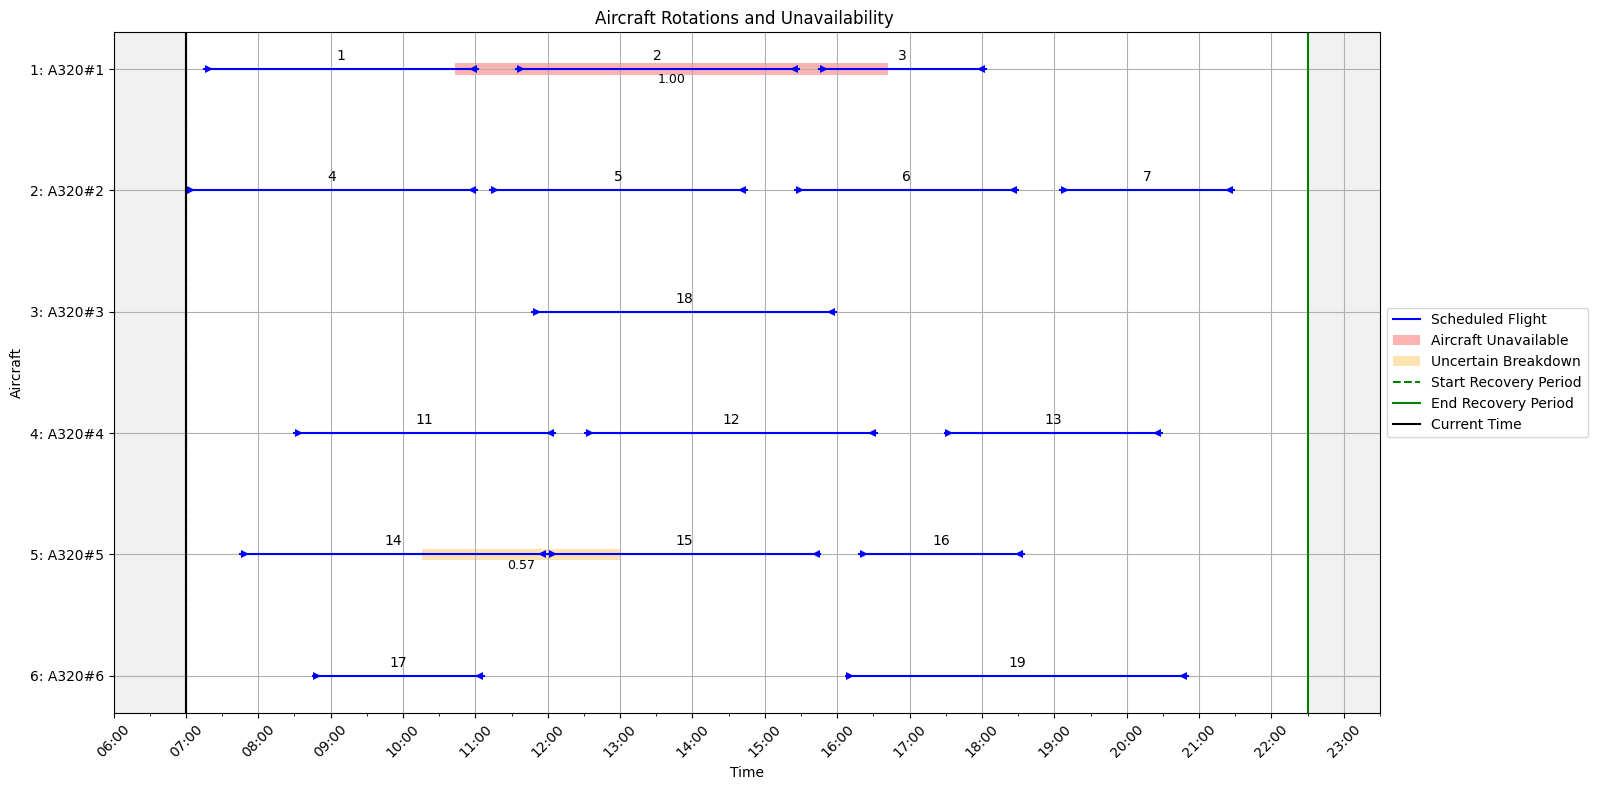

Processing scenario: Scenario_09
{'A320#1': {'StartDate': '25/09/24', 'StartTime': '09:13', 'EndDate': '25/09/24', 'EndTime': '17:13', 'Probability': 1.0}, 'A320#5': {'StartDate': '25/09/24', 'StartTime': '11:29', 'EndDate': '25/09/24', 'EndTime': '17:06', 'Probability': 0.51}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   1.00    253   733 |     1   225   355 |     2   379   660 |     3   667   801 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     4   135   343 |     5   360   650 |     6   673   804 |     7   839 

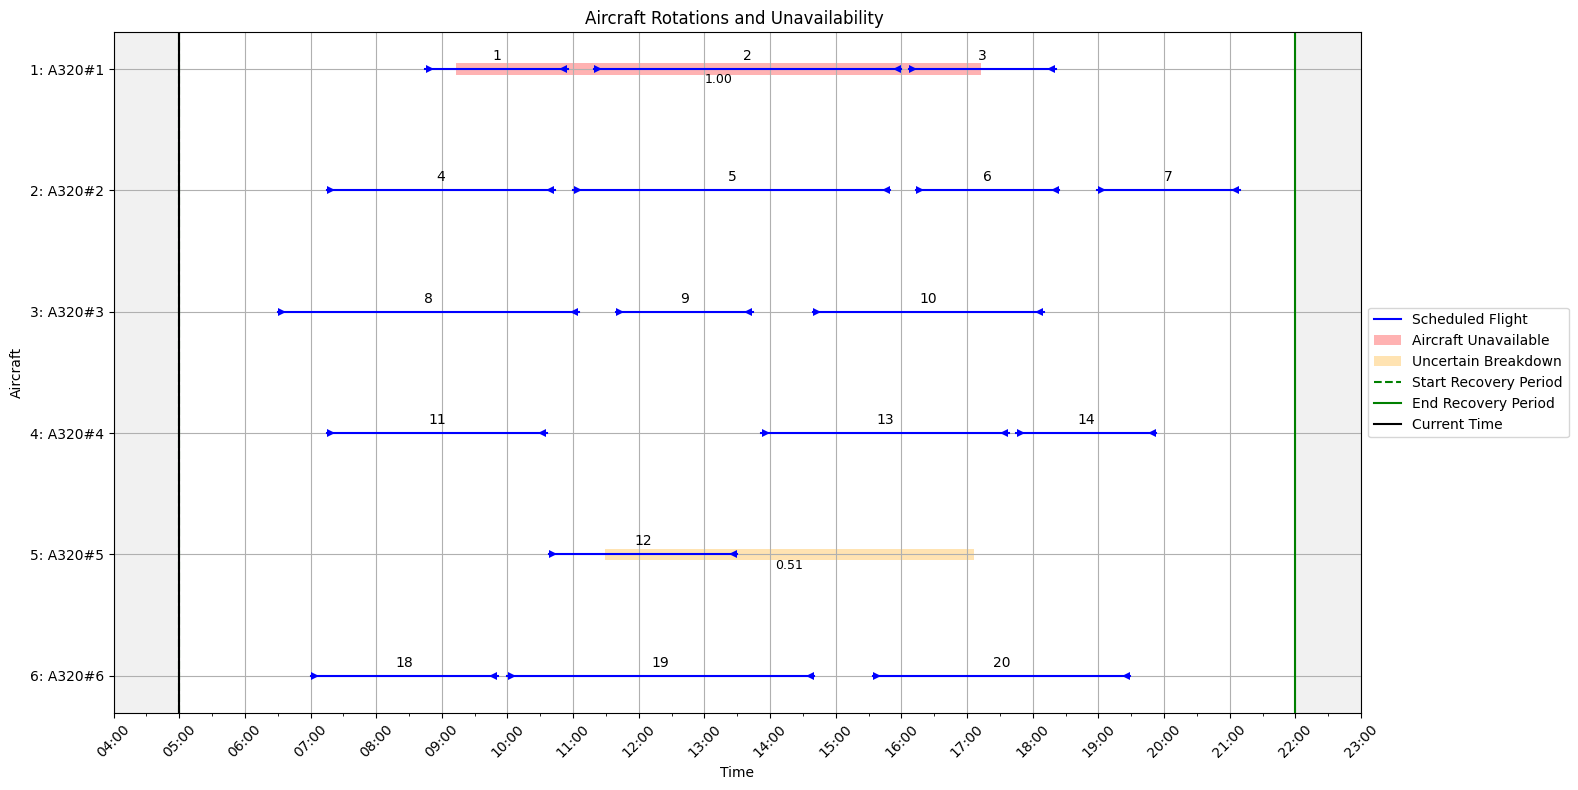

Processing scenario: Scenario_10
{'A320#6': {'StartDate': '18/09/24', 'StartTime': '08:39', 'EndDate': '18/09/24', 'EndTime': '13:35', 'Probability': 1.0}, 'A320#3': {'StartDate': '18/09/24', 'StartTime': '10:14', 'EndDate': '18/09/24', 'EndTime': '15:11', 'Probability': 0.76}}
│ Current Time       │ Time Until End     │   
│          0         │          0         │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1      -      -     - |     1    45   202 |     2   213   408 |     3   421   640 |     4   671   840 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2      -      -     - |     5   150   361 |     6   404   673 |     7   729   854 |     -     - 

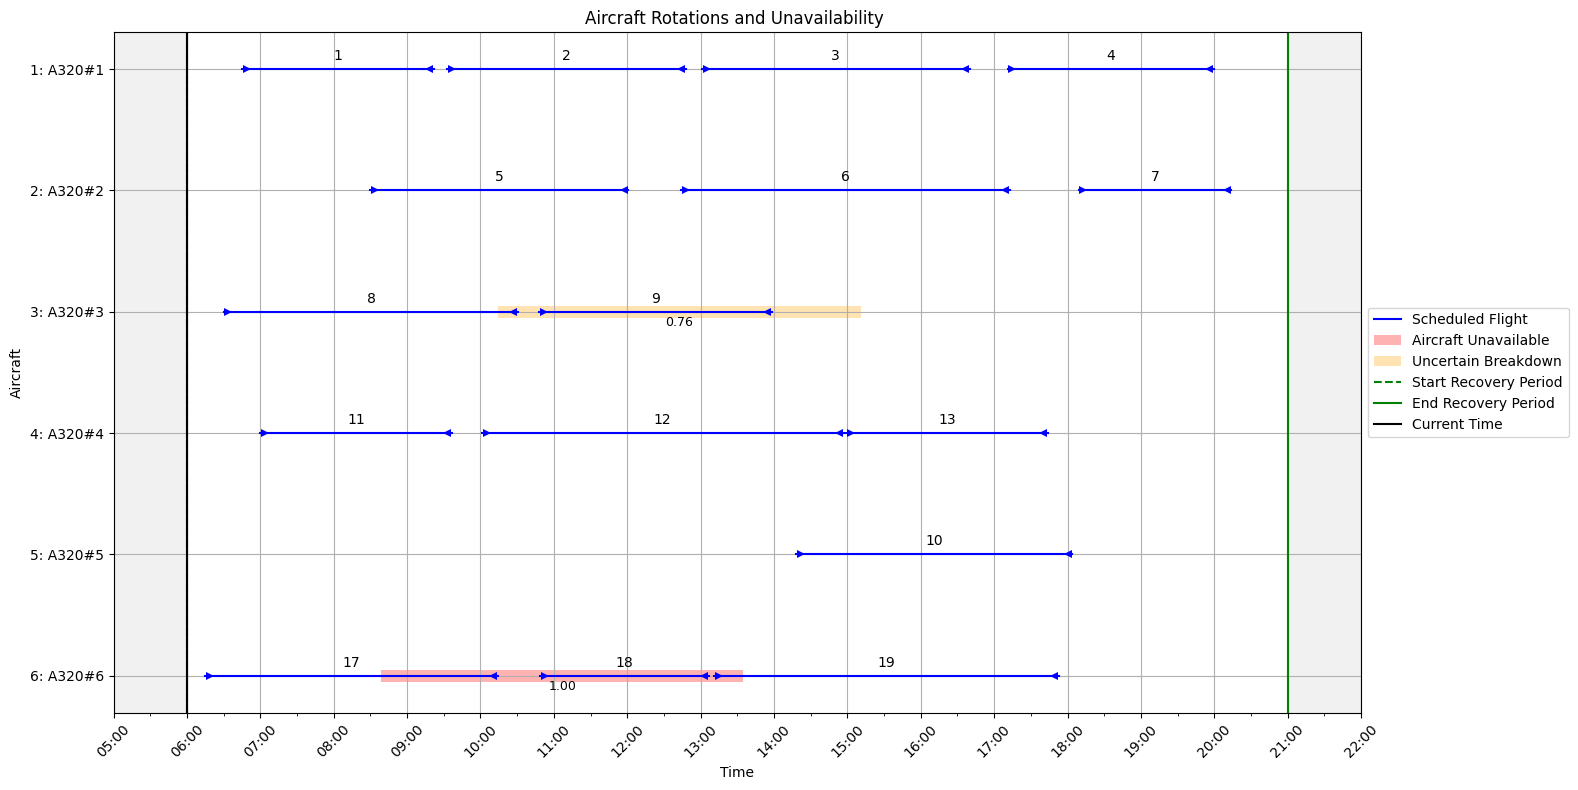

All scenarios processed successfully.


In [64]:
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
import os
from src.environment import AircraftDisruptionEnv
from datetime import datetime
from scripts.utils import print_state_nicely_proactive

env_type = 'proactive'


# Verify that the root folder exists
if not os.path.exists(data_root_folder):
    raise FileNotFoundError(f"The data root folder does not exist: {data_root_folder}")

# Get the list of scenarios, sorted by name in ascending order
scenarios = sorted(
    [scenario for scenario in os.listdir(data_root_folder) if os.path.isdir(os.path.join(data_root_folder, scenario))]
)
plotter_counter = 0
# Process each scenario
for scenario_name in scenarios:
    plotter_counter += 1
    if plotter_counter > 10:
        break

    scenario_path = os.path.join(data_root_folder, scenario_name)
    
    print(f"Processing scenario: {scenario_name}")

    # Verify that the scenario exists
    if not os.path.exists(scenario_path):
        print(f"Scenario {scenario_name} does not exist. Skipping...")
        continue

    # Load scenario data
    data_dict = load_scenario_data(scenario_path)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Print configuration details for verification
    # print(config_dict)

    # print alt_aircraft_dict
    print(alt_aircraft_dict)

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )
    # Print state with print_state_nicely_proactive
    print_state_nicely_proactive(env.state)
    
    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )



    # Define the recovery period based on provided configuration
    start_date = config_dict['RecoveryPeriod']['StartDate']
    start_time = config_dict['RecoveryPeriod']['StartTime']
    end_date = config_dict['RecoveryPeriod']['EndDate']
    end_time = config_dict['RecoveryPeriod']['EndTime']
    start_datetime = datetime.strptime(f"{start_date} {start_time}", '%d/%m/%y %H:%M')

    # Plot the state for the current scenario
    print(f"Plotting state for scenario: {scenario_name}")
    state_plotter.plot_state(flights_dict, [], [], set(), env.current_datetime)

print("All scenarios processed successfully.")
